# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np
%load_ext autoreload
%autoreload 2

### Define the linac and beams

In [18]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]

# define stage
stage = StageQuasistatic2d()
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 11 # [m]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.radiation_reaction = True

# define first stage (half length)
first_stage = StageQuasistatic2d()
first_stage.driver_source = stage.driver_source
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.radiation_reaction = stage.radiation_reaction

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 500

# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulations

In [19]:
linac.run('linac_example', num_shots=1, overwrite=True, parallel=False);

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 1.0% rms, 167.3/0.5 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 5.5 m, 21.1 GeV, -1.60 nC, 2.8% rms, 167.5/0.5 µm-rad)


### Plot the wakefield

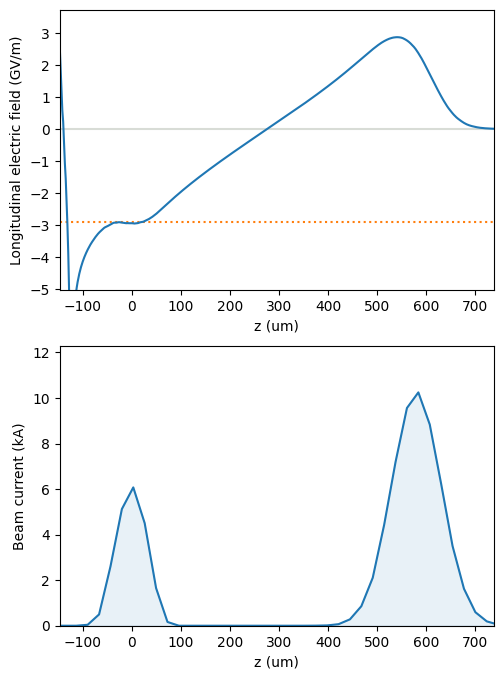

In [20]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

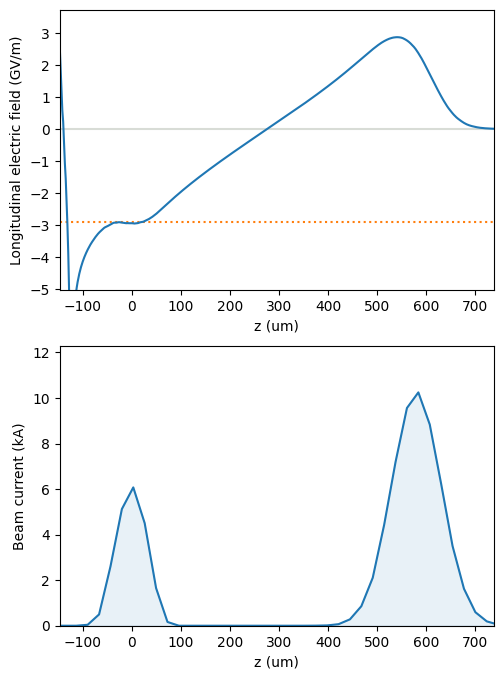

In [21]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

### Plot beam evolution and survey

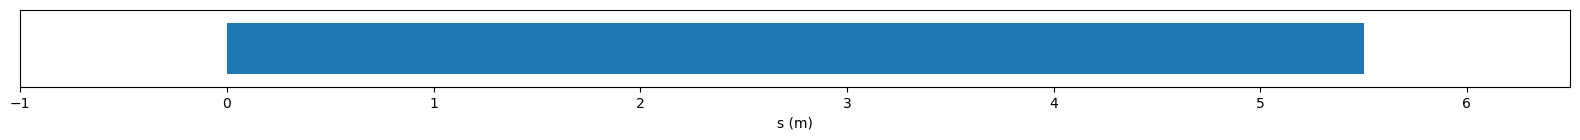

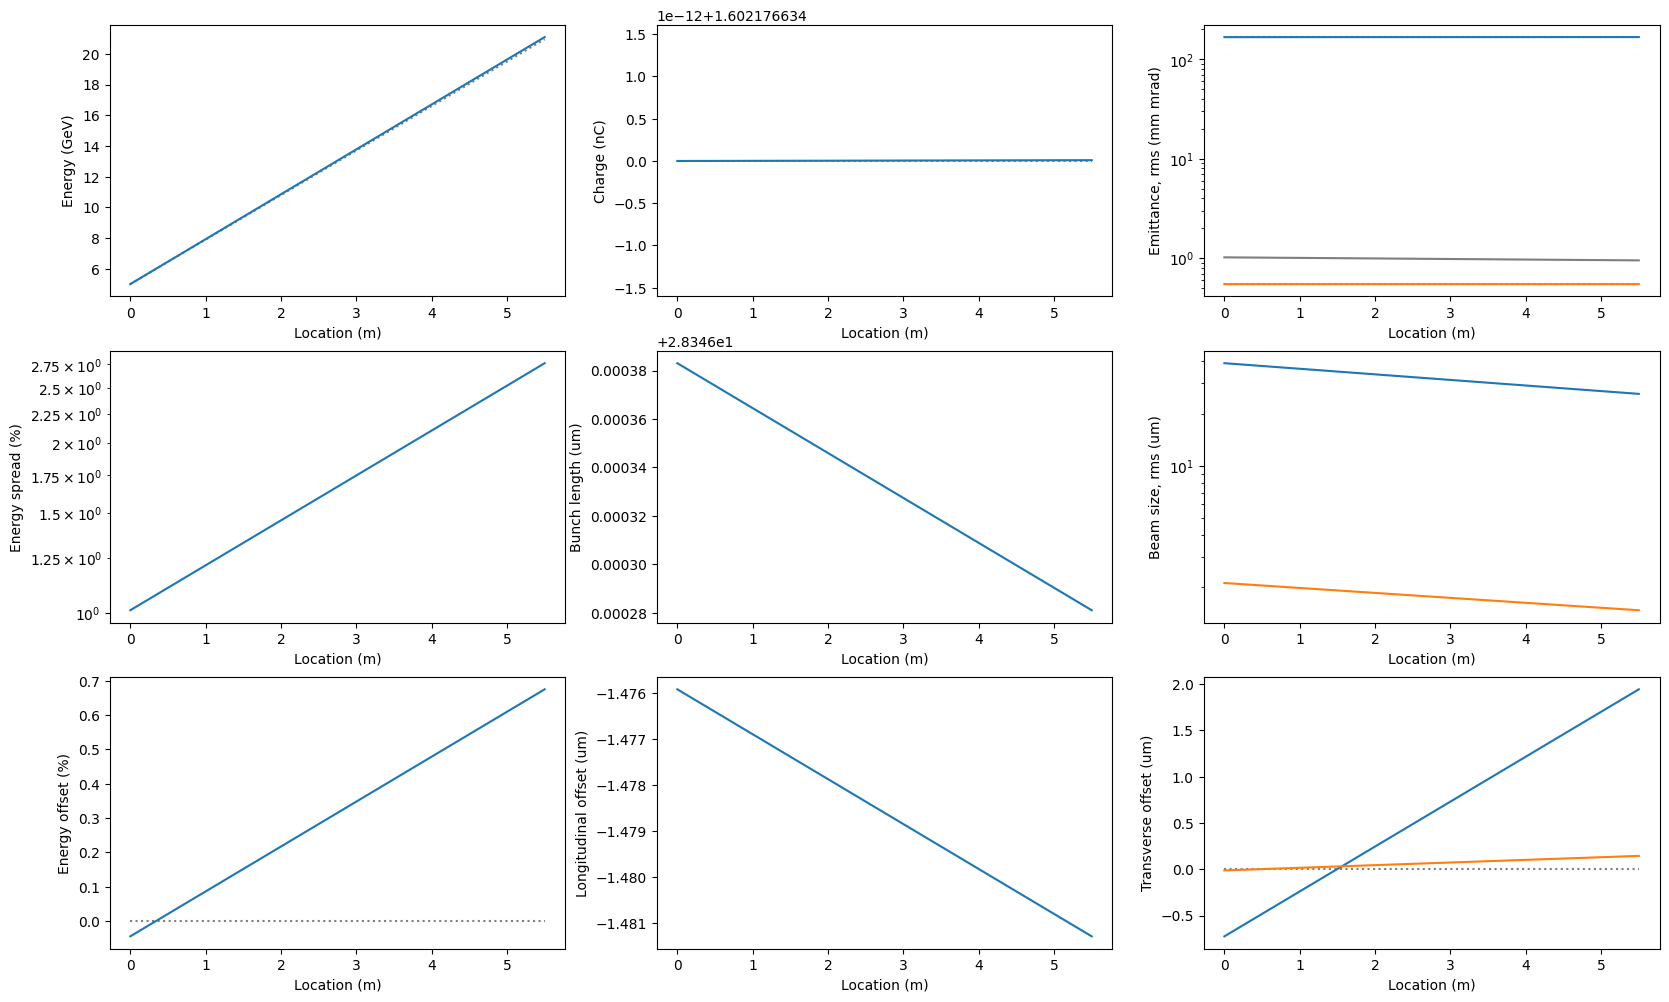

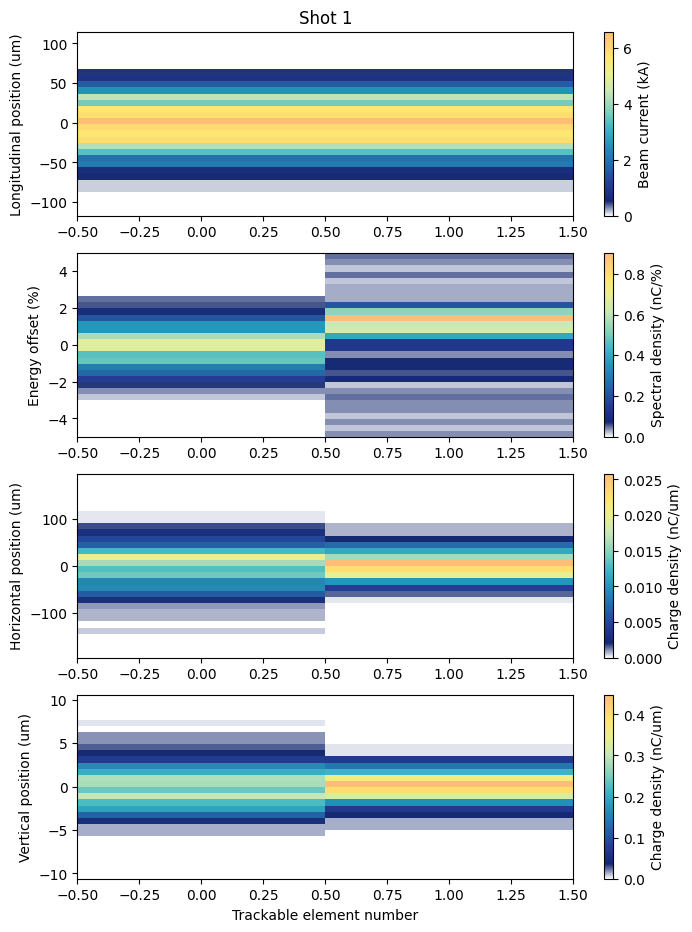

In [22]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution(use_stage_nums=False)
linac.plot_waterfalls()

In [23]:
linac.animate_lps()

'run_data/linac_example/plots/lps_shot0.gif'

![](run_data/linac_example/plots/lps_shot0.gif)

In [8]:
linac.animate_phasespace_x()

'run_data/linac_example/plots/phasespace_x_shot0.gif'

![](run_data/linac_example/plots/phasespace_x_shot0.gif)

In [9]:
linac.animate_phasespace_y()

'run_data/linac_example/plots/phasespace_y_shot0.gif'

![](run_data/linac_example/plots/phasespace_y_shot0.gif)

In [10]:
linac.animate_sideview_x()

'run_data/linac_example/plots/sideview_x_shot0.gif'

![](run_data/linac_example/plots/sideview_x_shot0.gif)

In [11]:
linac.animate_sideview_y()

'run_data/linac_example/plots/sideview_y_shot0.gif'

![](run_data/linac_example/plots/sideview_y_shot0.gif)